# VQE

The Variational Quantum Eigensolver (VQE) is a central algorithm in many applications from e.g. quantum chemistry or optimization.
This tutorial shows you how to run the VQE as a Qiskit Runtime program. We'll start off by defining the algorithm settings, such as the Hamiltonian and ansatz, and then run a VQE both locally, on your machine, and remotely, using the Qiskit Runtime.

**Note:** You can find tutorials on solving more comprehensive problems, such as finding the ground state of the lithium hydride molecule, using the VQE (and Qiskit Runtime) within [the tutorials of Qiskit Nature](https://github.com/Qiskit/qiskit-nature/tree/main/docs/tutorials).

## System Hamiltonian

Let's start by defining the operator of which we want to determine the ground state. Here we'll chose a simple diagonal Hamiltonian $\hat H$ acting with Pauli-Z operators on the first two qubits

$$
\hat H = \hat Z_0 \otimes \hat Z_1.
$$

We can construct this Hamiltonian with Qiskit's `opflow` module:

In [1]:
from qiskit.opflow import Z, I

num_qubits = 4
hamiltonian = (Z ^ Z) ^ (I ^ (num_qubits - 2))

This Hamiltonian has a ground state energy of -1.

In [2]:
target_energy = -1

## Parameterized Ansatz Circuit

Next, we choose a parameterized quantum circuit $\hat U(\theta)$ to prepare the ansatz wavefunction

$$
|\psi(\theta)\rangle = \hat U(\theta)|0\rangle.
$$

We'll use the `EfficientSU2` circuit from Qiskit's circuit library, which is a hardware efficient, heuristic ansatz with alternating rotation and entanglement layers.

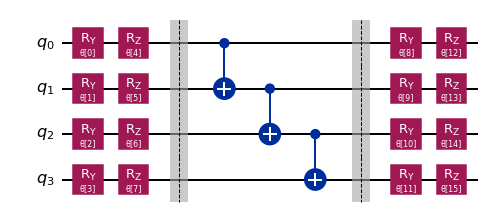

In [3]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.draw('mpl', style='iqx')

## Solve with the VQE

Now that we have the problem and ansatz specified we can use the Variational Quantum Eigensolver (VQE) to solve for the minimal eigenvalue of our Hamiltonian.

The VQE requires a classical optimization routine, along with an initial point, to calculate the parameter updates.

In [4]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=50)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

To access intermediate information we can pass a callback into the VQE. The callback is given the current number of function evaluations, the current parameters, function values and standard deviation in the expectation evaluation. 

In [5]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

### Local VQE

Before running the Qiskit Runtime VQE program, let's first simulate this system locally using Qiskit's `VQE` class.

In [6]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

In [7]:
local_result = local_vqe.compute_minimum_eigenvalue(hamiltonian)

In [8]:
print('Eigenvalue:', local_result.eigenvalue)
print('Target:', target_energy)

Eigenvalue: -0.994140625
Target: -1


With the information from the callback, we can for instance compute the average of the estimation errors in the expectation evaluations. For an exact (statevector) simulation this would be 0, but for a shot-based readout as we have on real hardware, this will be a small finite error.

In [9]:
print('Mean error:', np.mean(intermediate_info['stddev']))

Mean error: 0.014968352082564208


### Runtime VQE: ``VQEProgram``

To run the VQE using Qiskit Runtime, we only have to do very few changes from the local VQE run and mainly have to replace the `VQE` class by the `VQEProgram` class. Both follow the same `MinimumEigensolver` interface and thus share the `compute_minimum_eigenvalue` method to execute the algorithm and return the same type of result object. Merely the signature of the initializer differs sligthly.

We start by choosing the provider with access to the Qiskit Runtime service and the backend to execute the circuits on. 

**Note:** To run this tutorial, replace the provider by your provider.

In [10]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(project='qiskit-runtime')  # replace by your designated provider

We're using the IBM Montreal device, but you can replace this with another device that support the Qiskit Runtime.

In [11]:
backend = provider.get_backend('ibmq_montreal')

Let's not forget to reset the callback!

In [12]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

Since the Qiskit Runtime VQE runs on real hardware, we might want to do readout error mitigation. For this purpose the `VQEProgram` supports a boolean flag `readout_error_mitigation` that can be set to `True` to enable error mitigation with a complete measurement fitter.

In [13]:
readout_error_mitigation = True

In [14]:
from qiskit_runtime.vqe import VQEProgram

# in this first release, the optimizer must be specified as dictionary
optimizer = {'name': 'SPSA',
             'maxiter': 50}

runtime_vqe = VQEProgram(ansatz=ansatz,
                         optimizer=optimizer,
                         initial_point=initial_point,
                         provider=provider,
                         backend=backend,
                         shots=1024,
                         readout_error_mitigation=readout_error_mitigation,
                         callback=callback)

In [15]:
runtime_result = runtime_vqe.compute_minimum_eigenvalue(hamiltonian)

In [16]:
print('Eigenvalue:', runtime_result.eigenvalue)
print('Target:', target_energy)

Eigenvalue: -0.947692038031636
Target: -1


In [17]:
print('Mean error:', np.mean(intermediate_info['stddev']))

Mean error: (0.009295459418135251+0j)


Additionally to final results, the `VQEProgram` also returns the history of the optimization, such that we can visualize the 

In [18]:
history = runtime_result.optimizer_history

loss = history['loss']
timestamps = history['time']

runtimes = np.concatenate(([0], np.diff(timestamps)))
runtimes_in_min = runtimes / 60

From this, we can extract the times per iteration and statistics on it:

In [19]:
print(f'Total time taken: {np.sum(runtimes_in_min):.2f}min\n')

# note that the median and average might differ, since the device get's calibrated every hour
# resulting in some iteration times that are much larger than the rest
print(f'Median time of the iterations: {np.median(runtimes):.2f}s')
print(f'Average time per iteration: {np.mean(runtimes):.2f}s')
print(f'Standard deviation: {np.std(runtimes):.2f}s')

Total time taken: 24.77min

Median time of the iterations: 26.76s
Average time per iteration: 29.72s
Standard deviation: 13.35s


or plot the loss against the total time taken:

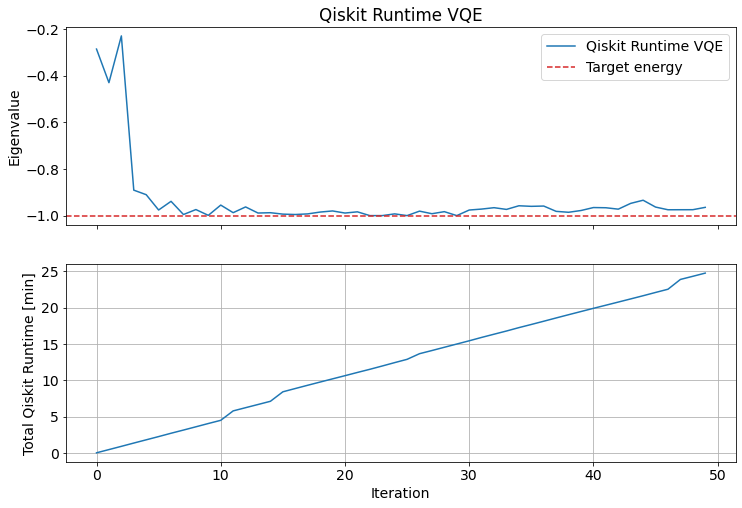

In [20]:
import matplotlib.pyplot as plt 

plt.rcParams['font.size'] = 14

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))

# plot loss and reference value
ax1.plot(loss, label='Qiskit Runtime VQE')
ax1.axhline(y=target_energy, color='tab:red', ls='--', label='Target energy')

# plot time taken
ax2.plot(np.cumsum(runtimes_in_min))

# settings
ax1.set_title('Qiskit Runtime VQE')
ax1.set_ylabel('Eigenvalue')
ax1.legend(loc='best')
ax2.set_ylabel('Total Qiskit Runtime [min]')
ax2.set_xlabel('Iteration')
ax2.grid();


### Qiskit Runtime VQE: Direct call

Instead of interacting with the Qiskit Runtime via the `VQEProgram` we can also directly call the the Qiskit Program in the cloud  -- like running the Quantum Kernel Alignment (QKA) or Circuit Runner. Under the hood, `VQEProgram` is nothing but a proxy that takes care of creating the dictionaries interaction with the Qiskit Program running in the Qiskit Runtime on the cloud.

To call the VQE code on the Qiskit Runtime on the cloud, we interact with the `run` method of the provider
```
provider.run(progam_id, inputs, options, callback)
```
where 
* `program_id` determines the Qiskit Runtime program run, i.e. `'vqe'` for the VQE
* `inputs` contains the input for the VQE algorithm
* `options` specifies the backend
* `callback` is the callback used inside the VQE

Let's gather all the inputs to the VQE in a dictionary.

In [21]:
vqe_inputs = {
    'ansatz': ansatz,
    'operator': hamiltonian,
    'optimizer': {'name': 'SPSA', 'maxiter': 5},  # let's only do a few iterations!
    'initial_point': initial_point,
    'readout_error_mitigation': True,
    'shots': 1024
}

The backend options only need to contain the name of the backend.

In [22]:
backend_options = {
    'backend_name': backend.name()
}

The callback acts a little different than before. Instead of only being passed the VQE callback arguments, it is passed a tuple with the job ID as first argument, followed by the VQE arguments.

In [23]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def raw_callback(*args):
    job_id, (nfev, parameters, energy, stddev) = args
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

Now we can call the Qiskit Runtime VQE directly, without going through the convenience of the `VQEProgram`. 
Note, that the result will not be of the same type as `VQE` or `VQEProgram`, but a plain dictionary.

In [24]:
job = provider.runtime.run(
    program_id='vqe',
    inputs=vqe_inputs,
    options=backend_options,
    callback=raw_callback
)
print('Job ID:', job.job_id())

Job ID: c2aga1418tu3tem8ghn0


In [25]:
result = job.result()

In [30]:
print(f'Reached {result["optimal_value"]} after {result["optimizer_evals"]} evaluations.')

Reached -0.41066745294814644 after 16 evaluations.


In [31]:
print('Available keys:', list(result.keys()))

Available keys: ['optimizer_evals', 'optimizer_time', 'optimal_value', 'optimal_point', 'optimal_parameters', 'cost_function_evals', 'eigenstate', 'eigenvalue', 'aux_operator_eigenvalues', 'optimizer_history']
